In [1]:
import os
import pickle
import re

import matplotlib
from matplotlib import pyplot
import numpy
import pandas
import scipy
import seaborn
import tensorflow.keras
from sklearn import preprocessing

import logomaker

# Helper functions

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['legend.fontsize'] = 'small'
pandas.options.display.max_columns = None
pandas.options.display.max_colwidth = None

In [3]:
# Helper functions
def one_hot_encode(sequences, max_seq_len=None, mask_val=-1, padding='left'):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],
             'c':[0,1,0,0],
             'g':[0,0,1,0],
             't':[0,0,0,1],
             'n':[0,0,0,0]}

    # Automatically use max length if not specified
    if max_seq_len is None:
        max_seq_len = numpy.max([len(s) for s in sequences])
    
    # Creat empty matrix
    one_hot_seqs = numpy.ones([len(sequences), max_seq_len, 4])*mask_val
    
    # Iterate through sequences and one-hot encode
    for i, seq in enumerate(sequences):
        # Truncate
        if padding=='left':
            seq = seq[:max_seq_len]
        elif padding=='right':
            seq = seq[-max_seq_len:]
        else:
            raise ValueError(f'padding {padding} not recognized')
        # Convert to array
        seq = seq.lower()
        one_hot_seq = numpy.array([nuc_d[x] for x in seq])
        # Append to matrix
        if padding=='left':
            one_hot_seqs[i, :len(seq), :] = one_hot_seq
        elif padding=='right':
            one_hot_seqs[i, -len(seq):, :] = one_hot_seq
        else:
            raise ValueError(f'padding {padding} not recognized')
            
    return one_hot_seqs

# Load data

In [4]:
datasets = [
    {
        'cell_line': 'HEK293T',
        'replicate': 1,
        'path': '../polysome_profiling_sample2019/GSM3130435_egfp_unmod_1.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total_reads'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total_reads': 'Reads'},
    },
    {
        'cell_line': 'HEK293T',
        'replicate': 2,
        'path': '../polysome_profiling_sample2019/GSM3130436_egfp_unmod_2.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'T cells',
        'replicate': 1,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_tcell_r1.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'T cells',
        'replicate': 2,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_tcell_r2.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'HepG2',
        'replicate': 1,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_hepg2_r1.csv.gz',
        'cols_to_load': ['UTR', 'rl', 'total'],
        'cols_to_rename': {'rl': 'MRL', 'total': 'Reads'},
    }
]

In [5]:
# Load, preprocess, and compile data
multicol = pandas.MultiIndex(
    levels=[[], [], []],
    codes=[[], [], []],
    names=['Measurement', 'Cell type', 'Replicate'],
)
data_table_combined = pandas.DataFrame(columns=multicol)

for dataset in datasets:
    # Load only desired columns, rename
    data_table = pandas.read_csv(dataset['path'], usecols=dataset['cols_to_load'])
    data_table.rename(columns=dataset['cols_to_rename'], inplace=True)
    data_table['UTR'] = data_table['UTR'].str[:50]
    data_table = data_table.set_index('UTR')
    # Eliminate the large number of sequences with one read
    data_table = data_table[data_table['Reads'] > 1]

    # Convert to multiindex
    data_table = data_table[['Reads', 'MRL']]
    multicol = pandas.MultiIndex.from_product(
        [['Reads', 'MRL'], [dataset['cell_line']], [dataset['replicate']]],
        names=['Measurement', 'Cell type', 'Replicate'],
    )
    data_table.columns = multicol

    # Store
    data_table_combined = data_table_combined.merge(data_table, how='outer', left_index=True, right_index=True)
    
    print("{:,} sequences loaded for cell line {} rep {}.".format(len(data_table), dataset['cell_line'], dataset['replicate']))

# Set NaN reads to zero
data_table_combined['Reads'] = data_table_combined['Reads'].fillna(0)

# Add uATG
data_table_combined['uATG'] = False
data_table_combined.loc[data_table_combined.index.str.contains('ATG'), 'uATG'] = True
# data_table_combined.loc[~data_table_combined.index.str.contains('ATG'), 'uATG'] = False

display(data_table_combined)

326,033 sequences loaded for cell line HEK293T rep 1.
351,575 sequences loaded for cell line HEK293T rep 2.
349,633 sequences loaded for cell line T cells rep 1.
352,724 sequences loaded for cell line T cells rep 2.
789,594 sequences loaded for cell line HepG2 rep 1.


Measurement,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,uATG
Cell type,HEK293T,HEK293T,HEK293T,HEK293T,T cells,T cells,T cells,T cells,HepG2,HepG2,
Replicate,1,1,2,2,1,1,2,2,1,1,
UTR,,,,,,,,,,,
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,4.0,6.436631,False
AAAAAAAAAAACAAGAACCCAGGTGGGTCTAGAGAAGGGATAGAAGCTCC,17.0,7.925491,28.0,7.464286,0.0,NaN,0.0,NaN,0.0,NaN,False
AAAAAAAAAAACTAAACAAAGACTAAGCTGCGGTCAGATATGTTAAACAA,11.0,10.011610,16.0,6.125000,0.0,NaN,0.0,NaN,0.0,NaN,True
AAAAAAAAAACTATACTAGGAAAGACATATTGCTAGGGATGCTCTGGGAT,0.0,NaN,0.0,NaN,5.0,0.000000,0.0,NaN,0.0,NaN,True
AAAAAAAAAACTATACTAGGAAAGACATCATGCTAGGGATGCTCTGGGAT,0.0,NaN,2.0,11.000000,0.0,NaN,0.0,NaN,0.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTTTGAGTTAGAAAACATTGGATCGGTCCGGGTCAAAGGGGAGATC,481.0,8.692710,159.0,7.050314,56.0,6.170554,111.0,7.805348,292.0,4.882561,False


In [6]:
# Load optimus 5-prime model
# model file downloaded from Sample 2019 github repo
# https://github.com/pjsample/human_5utr_modeling/tree/master/modeling/saved_models/main_MRL_model.hdf5
model = tensorflow.keras.models.load_model('../models_sample2019/main_MRL_model.hdf5')
model.summary()

# Set output scaler from the training data
data_scaler = data_table_combined.loc[:, (slice(None), 'HEK293T', 1)].droplevel([1, 2], axis=1)
data_scaler = data_scaler.sort_values('Reads', ascending=False)
data_scaler = data_scaler.iloc[20000:280000]
scaler = preprocessing.StandardScaler()
scaler.fit(data_scaler['MRL'].values.reshape(-1,1))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 50, 120)           3960      
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 120)           115320    
                                                                 
 dropout_1 (Dropout)         (None, 50, 120)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 120)           115320    
                                                                 
 dropout_2 (Dropout)         (None, 50, 120)           0         
                                                                 
 flatten_1 (Flatten)         (None, 6000)              0         
                                                                 
 dense_1 (Dense)             (None, 40)                2

StandardScaler()

In [7]:
# Retain only sequences with high read counts in HEK293
data_table_high_hek = data_table_combined.sort_values(('Reads', 'HEK293T', 1), ascending=False)
data_table_high_hek = data_table_high_hek.iloc[:20000]

data_table_high_hek

Measurement,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,uATG
Cell type,HEK293T,HEK293T,HEK293T,HEK293T,T cells,T cells,T cells,T cells,HepG2,HepG2,
Replicate,1,1,2,2,1,1,2,2,1,1,
UTR,,,,,,,,,,,
CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,12126.0,3.039939,2633.0,2.688568,4900.0,1.995057,3865.0,2.583809,2955.0,1.846297,True
CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,10368.0,3.895109,2138.0,3.855005,2598.0,3.531917,2395.0,3.925099,2639.0,2.166412,True
GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGACGCGA,9963.0,3.334524,1852.0,3.052376,2449.0,2.556166,1821.0,3.858667,1713.0,1.877059,True
CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGTAAAC,9934.0,3.575082,1916.0,3.122651,2727.0,3.158766,2201.0,4.021475,2333.0,2.220275,True
GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTCCGCC,9511.0,4.593712,1406.0,4.172119,2432.0,4.279264,2145.0,5.073864,2324.0,2.856972,True
...,...,...,...,...,...,...,...,...,...,...,...
GTGTAAGGCTCTGGTGGGCACACGTCGGTTTGCAGTAATGACAGACACGT,2497.0,3.787840,317.0,3.561514,395.0,3.214630,952.0,4.026118,173.0,2.902870,True


In [8]:
# Make predictions
data_table_high_hek.loc[:, ('MRL', 'Prediction', 1)] = scaler.inverse_transform(
    model.predict(
        one_hot_encode(data_table_high_hek.index)
    ).reshape(-1, 1)
)

data_table_high_hek

Measurement,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,uATG,MRL
Cell type,HEK293T,HEK293T,HEK293T,HEK293T,T cells,T cells,T cells,T cells,HepG2,HepG2,,Prediction
Replicate,1,1,2,2,1,1,2,2,1,1,,1
UTR,,,,,,,,,,,,
CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,12126.0,3.039939,2633.0,2.688568,4900.0,1.995057,3865.0,2.583809,2955.0,1.846297,True,3.180903
CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,10368.0,3.895109,2138.0,3.855005,2598.0,3.531917,2395.0,3.925099,2639.0,2.166412,True,4.124235
GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGACGCGA,9963.0,3.334524,1852.0,3.052376,2449.0,2.556166,1821.0,3.858667,1713.0,1.877059,True,3.900774
CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGTAAAC,9934.0,3.575082,1916.0,3.122651,2727.0,3.158766,2201.0,4.021475,2333.0,2.220275,True,3.858222
GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTCCGCC,9511.0,4.593712,1406.0,4.172119,2432.0,4.279264,2145.0,5.073864,2324.0,2.856972,True,4.903222
...,...,...,...,...,...,...,...,...,...,...,...,...
GTGTAAGGCTCTGGTGGGCACACGTCGGTTTGCAGTAATGACAGACACGT,2497.0,3.787840,317.0,3.561514,395.0,3.214630,952.0,4.026118,173.0,2.902870,True,4.005191


Measurement,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,uATG,MRL,Reads
Cell type,HEK293T,HEK293T,HEK293T,HEK293T,T cells,T cells,T cells,T cells,HepG2,HepG2,,Prediction,min
Replicate,1,1,2,2,1,1,2,2,1,1,,1,
UTR,,,,,,,,,,,,,
CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,12126.0,3.039939,2633.0,2.688568,4900.0,1.995057,3865.0,2.583809,2955.0,1.846297,True,3.180903,2633.0
CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,10368.0,3.895109,2138.0,3.855005,2598.0,3.531917,2395.0,3.925099,2639.0,2.166412,True,4.124235,2138.0
GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGACGCGA,9963.0,3.334524,1852.0,3.052376,2449.0,2.556166,1821.0,3.858667,1713.0,1.877059,True,3.900774,1713.0
CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGTAAAC,9934.0,3.575082,1916.0,3.122651,2727.0,3.158766,2201.0,4.021475,2333.0,2.220275,True,3.858222,1916.0
GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTCCGCC,9511.0,4.593712,1406.0,4.172119,2432.0,4.279264,2145.0,5.073864,2324.0,2.856972,True,4.903222,1406.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTGTAAGGCTCTGGTGGGCACACGTCGGTTTGCAGTAATGACAGACACGT,2497.0,3.787840,317.0,3.561514,395.0,3.214630,952.0,4.026118,173.0,2.902870,True,4.005191,173.0


With uAUG    13807
No uAUG       5931
Name: uATG string, dtype: int64


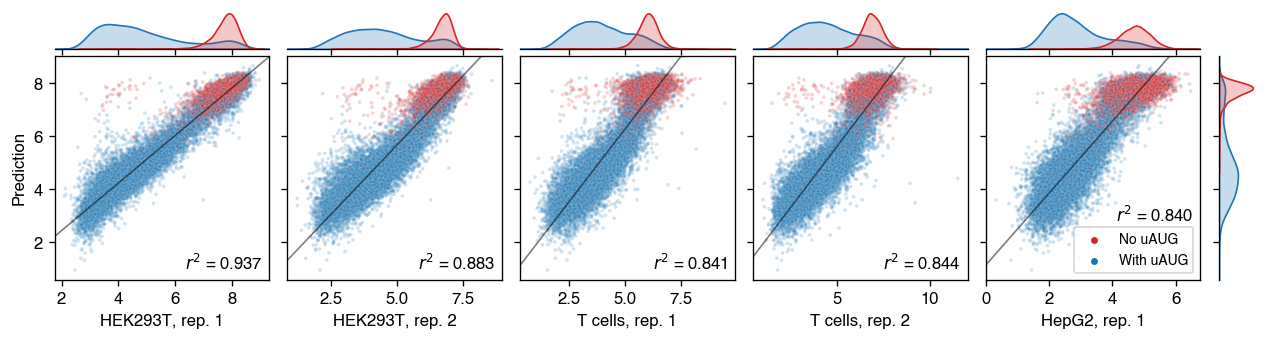

In [9]:
# Plot cell line vs. prediction

# Preprocess data
data_to_plot = data_table_high_hek.copy()
# Get minimum number of reads across datasets
data_to_plot[('Reads', 'min', '')] = data_to_plot.loc[:, 'Reads'].min(axis=1)
# Eliminate sequences with really low read numbers
data_to_plot = data_to_plot[data_to_plot[('Reads', 'min', '')] > 100]
display(data_to_plot)
# Randomize order
data_to_plot = data_to_plot.sample(frac=1)
# Assign whether uAUGs are present in the sequence
data_to_plot.loc[data_to_plot['uATG'], 'uATG string'] = 'With uAUG'
data_to_plot.loc[~data_to_plot['uATG'], 'uATG string'] = 'No uAUG'
print(data_to_plot['uATG string'].value_counts())

marginal_size_ratio = 6
fig = pyplot.figure(figsize=(2.5*len(datasets), 2.8))
gs = fig.add_gridspec(
    2,
    len(datasets) + 1, 
    width_ratios=[marginal_size_ratio]*len(datasets) + [1],
    height_ratios=(1, marginal_size_ratio),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.1,
    hspace=0.05,
)

for dataset_idx, dataset in enumerate(datasets):
    ax_joint = fig.add_subplot(gs[1, dataset_idx])
    ax_marginal_x = fig.add_subplot(gs[0, dataset_idx])
    if dataset_idx == (len(datasets) - 1):
        ax_marginal_y = fig.add_subplot(gs[1, len(datasets)])
    else:
        ax_marginal_y = None

    cell_line_x = dataset['cell_line']
    replicate_x = dataset['replicate']
    cell_line_y = 'Prediction'
    replicate_y = 1

    # Redefine columns for scatterplot
    xcol_name = f"{cell_line_x}, rep. {replicate_x}"
    ycol_name = f"{cell_line_y}"
    data_subplot = data_to_plot[[('MRL', cell_line_x, replicate_x), ('MRL', cell_line_y, replicate_y), ("uATG string", '', '')]]
    data_subplot.columns = [xcol_name, ycol_name, "uATG string"]

    # Actually plot
    seaborn.scatterplot(
        data=data_subplot,
        x=xcol_name,
        y=ycol_name,
        hue="uATG string",
        ax=ax_joint,
        palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
        s=5,
        linewidth=0.2,
        alpha=0.2,
        edgecolor='white',
        rasterized=True,
        legend='auto' if dataset_idx==(len(datasets) - 1) else False,
    )

    # Regression line and r^2 text
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        data_subplot[xcol_name].values,
        data_subplot[ycol_name].values,
    )
    ax_joint.axline((3, 3*slope + intercept), slope=slope, color='k', linewidth=1, alpha=0.5)
    # r2_text = f'$r^2$ = {r_value**2:.3f}\nn = {len(data_subplot):,}'
    r2_text = f'$r^2$ = {r_value**2:.3f}'

    # ax.set_xlim(0, 10)
    # ax.set_xticks([0, 2, 4, 6, 8, 10])

    xlim = ax_joint.get_xlim()
    ylim = ax_joint.get_ylim()
    if dataset_idx==len(datasets) - 1:
        legend = ax_joint.get_legend()
        legend.set_title(None)
        for lh in legend.legendHandles:
            lh.set_alpha(1)
            lh.set_sizes([10])
        xcoord = xlim[0] + 0.97*(xlim[1] - xlim[0])
        ycoord = ylim[0] + 0.25*(ylim[1] - ylim[0])
        ax_joint.text(xcoord, ycoord, r2_text, ha='right', va='bottom')
    else:
        xcoord = xlim[0] + 0.97*(xlim[1] - xlim[0])
        ycoord = ylim[0] + 0.05*(ylim[1] - ylim[0])
        ax_joint.text(xcoord, ycoord, r2_text, ha='right')
    if dataset_idx!=0:
        ax_joint.set_ylabel('')
        ax_joint.set_yticklabels([])

    seaborn.kdeplot(
        data=data_subplot,
        x=xcol_name,
        hue="uATG string",
        palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
        legend=False,
        fill=True,
        # element="step",
        # bins=numpy.linspace(ax_joint.get_xlim()[0], ax_joint.get_xlim()[1], 50),
        ax=ax_marginal_x,
    )
    ax_marginal_x.set_xlim(ax_joint.get_xlim())
    ax_marginal_x.spines[['top', 'right', 'left']].set_visible(False)
    ax_marginal_x.set_xlabel('')
    ax_marginal_x.set_ylabel('')
    ax_marginal_x.set_xticklabels([])
    ax_marginal_x.set_yticks([])

    if dataset_idx == (len(datasets) - 1):
        seaborn.kdeplot(
            data=data_subplot,
            y=ycol_name,
            hue="uATG string",
            palette={'With uAUG': 'tab:blue', 'No uAUG': 'tab:red'},
            legend=False,
            fill=True,
            # element="step",
            # bins=numpy.linspace(ax_joint.get_ylim()[0], ax_joint.get_ylim()[1], 50),
            ax=ax_marginal_y,
        )
        ax_marginal_y.set_ylim(ax_joint.get_ylim())
        ax_marginal_y.spines[['top', 'right', 'bottom']].set_visible(False)
        ax_marginal_y.set_xlabel('')
        ax_marginal_y.set_ylabel('')
        ax_marginal_y.set_yticklabels([])
        ax_marginal_y.set_xticks([])

fig.savefig(f'mrl_vs_predictions_scatter.svg', dpi=300, bbox_inches='tight')
fig.savefig(f'mrl_vs_predictions_scatter.png', dpi=300, bbox_inches='tight')

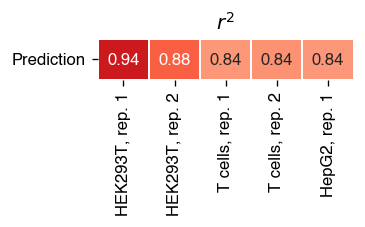

In [10]:
# Plot cell line vs. prediction, r^2 heatmap
r2_matrix = numpy.zeros((1, len(datasets)))

for dataset_idx, dataset in enumerate(datasets):

    cell_line_x = dataset['cell_line']
    replicate_x = dataset['replicate']
    cell_line_y = 'Prediction'
    replicate_y = 1

    # Redefine columns for scatterplot
    xcol_name = f"{cell_line_x}, rep. {replicate_x}"
    ycol_name = f"{cell_line_y}"
    data_subplot = data_to_plot[[('MRL', cell_line_x, replicate_x), ('MRL', cell_line_y, replicate_y)]]
    data_subplot.columns = [xcol_name, ycol_name]

    # Calculate r^2
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        data_subplot[xcol_name].values,
        data_subplot[ycol_name].values,
    )

    r2_matrix[0, dataset_idx] = r_value**2

# Make dataframe with axis labels
xlabels = [
    f'{datasets[i]["cell_line"]}, rep. {datasets[i]["replicate"]}'
    for i in range(len(datasets))
]
ylabels = ['Prediction']
r2_df = pandas.DataFrame(r2_matrix, index=ylabels, columns=xlabels)

# Plot heatmap
fig, ax = pyplot.subplots(figsize=(2.75, 0.44))
seaborn.heatmap(
    r2_df,
    annot=True,
    fmt='0.2f',
    vmin=0.75,
    vmax=1,
    ax=ax,
    cbar=False,
    # cbar_kws={'label': '$r^2$', 'aspect': 15},
    # edgecolors='k',
    linewidths=1,
    cmap='Reds',
)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
ax.set_title('$r^2$')

fig.savefig(f'mrl_vs_predictions_heatmap.svg', dpi=300, bbox_inches='tight')
fig.savefig(f'mrl_vs_predictions_heatmap.png', dpi=300, bbox_inches='tight')